In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import sys
import json
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from numpy import linalg as LA
from sklearn import linear_model
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric
from scipy.spatial import distance
from sklearn.cluster import KMeans

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from tools_lnd import get_T_inds, plot_FP_jitter, plot_N, TDR_axes, out_axes
from tools_lnd import make_axes, same_stim_trial, generate_Beta_epoch, take_names, make_FP_axs
from tools_lnd import make_h_trial_rule, get_model_params, gen_trials_from_model_dir, gen_X_from_model_dir

In [3]:
model_n = 0
task_list = ['delaygo','delayanti']
rule = task_list[0]
which_net = 'l2w0001'
fldr = 'two_tasks'
supp = []#'long_train'

if fldr == 'two_tasks':
    s = '_'
    rule_trains_str = s.join(task_list)
    file_spec = os.path.join(fldr,which_net+'_'+rule_trains_str)
else:
    file_spec = which_net
    
dir_specific_all = os.path.join('crystals','softplus',file_spec)#,supp)
    
m_all = os.path.join(p,'data/rnn/multitask/',net,dir_specific_all,str(model_n))
h_all,trial_all,tasks_all = make_h_trial_rule(m_all,mode = 'test',noise_on = False)

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_delaygo_delayanti/0/model.ckpt


In [4]:
m = m_all
model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    trial = generate_trials(rule, hparams, mode='random', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    
    n_input = hparams['n_input']
    n_rnn = hparams['n_rnn']
    n_output = hparams['n_output']
    w_in = params[0]
    b_in = params[1]
    w_out = params[2]
    b_out = params[3]
    sigma_rec = 0#hparams['sigma_rec']
    dt = hparams['dt']
    tau = hparams['tau']
    alpha = dt/tau
    activation = hparams['activation']

if activation == 'softplus':
    _activation = lambda x: np.log(np.exp(x) + 1)
elif activation == 'tanh':
    _activation = lambda x: np.tanh(x)
elif activation == 'relu':
    _activation = lambda x: x * (x > 0)
elif activation == 'power':
    _activation = lambda x: (x * (x > 0))**2
elif activation == 'retanh':
    _activation = lambda x: np.tanh(x * (x > 0))

def out_affine(params, h):
    return np.dot(params[2].T,h)+params[3]

def relu(x):
    f = x * (x > 0)
    return f

def rnn_vanilla(params, h, x, alpha):
    xh = np.concatenate([x,h], axis=0)
    gate_inputs = np.dot(params[0].T,xh)+params[1]
    noise = 0
    output = _activation(gate_inputs) # + noise

    h_new = (1-alpha) * h + alpha * output
    
    return h_new

def vanilla_run_with_h0(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(np.expand_dims(h0,axis=1))
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))

    h_t = np.squeeze(np.array(h_t))  
    return h_t

def vanilla_run_at_fp(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(h)
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))
        
    return h_t

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_delaygo_delayanti/0/model.ckpt


In [5]:
def plot_initXtasks(rule_ic_set, rule_in_set, c):
    
    output_labels = ['fixation',r' $\sin{\theta}$',r' $\cos{\theta}$']

    for rule_ic in rule_ic_set['set']:
        t_ind = trial_all[rule_ic].epochs['fix1'][1]-1
        b = 0 #trial number for now
        h0 = h_all[rule_ic][t_ind,b,:]

        for rule_in in rule_in_set['set']:
            t_start = trial_all[rule_in].epochs['fix1'][1]
            t_end = len(trial_all[rule_in].x)
            n_steps = t_end - t_start

            h_t = np.empty((n_steps,n_rnn))
            y_hat = np.empty((n_steps,n_output))
            x_t = trial_all[rule_in].x[range(t_start,t_end),b,:]
            h = h0
            for ti in range(t_end-t_start):
                h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x_t[ti,:]), alpha)
                h_t[ti,:] = h
                y_hat[ti,:] = out_affine(params, h_t[ti,:])

            for out_ind in range(n_output):
                ax = plt.subplot(1,3,out_ind+1)
                plt.plot(y_hat[:,out_ind],c,label = rule_ic + ' ic', alpha = .2,linewidth = 2)
                plt.plot(trial_all[rule_in].y[t_start:t_end,b,out_ind],':'+c,label = rule_in + ' target',linewidth = 2)
                plt.text(0,-.5,output_labels[out_ind])
                plt.ylim((-1.2,1.2))
                
                ax.spines['right'].set_visible(False)
                ax.spines['top'].set_visible(False)
                if out_ind == 1:
                    plt.title(rule_ic_set['set_name']+' ic, '+ rule_in_set['set_name']+ ' input')
                    plt.legend(('ouput','target'),fontsize = 14)
                else:
                    ax.spines['left'].set_visible(False)
                    ax.spines['bottom'].set_visible(False)
                    ax.get_xaxis().set_ticks([])
                    ax.get_yaxis().set_ticks([])

In [6]:
fdgo_tasks = {'set_name':'DelayPro','set':['fdgo',]}
fdanti_tasks = {'set_name':'DelayAnti','set':['fdanti',]}
delay_tasks = {'set_name':['DelayPro','DelayAnti'],'set':['fdgo','fdanti']}

In [7]:
plt.rcParams.update({'font.size': 18})
figpath = os.path.join(p,'code','overleaf','task_schematic_multitask','figs','interp_fps_mov',file_spec,str(model_n))
if not os.path.exists(figpath):
    os.makedirs(figpath)

fig = plt.figure(figsize=(6, 2.5))
plot_initXtasks(fdgo_tasks, fdanti_tasks, 'g')
figname = 'fdgoIN_example_output.pdf'
plt.savefig(os.path.join(figpath,figname), bbox_inches = 'tight')
plt.show()

fig = plt.figure(figsize=(6, 2.5))
plot_initXtasks(fdanti_tasks, fdgo_tasks, 'r')
figname = 'fdantiIN_example_output.pdf'
plt.savefig(os.path.join(figpath,figname), bbox_inches = 'tight')
plt.show()

KeyError: 'fdgo'

<Figure size 432x180 with 0 Axes>

In [8]:
def quant_perf(rule_ic_set, rule_in_set):
    for rule_ic in rule_ic_set['set']:
        t_ind = trial_all[rule_ic].epochs['fix1'][1]-1
        
        ri = 0
        for rule_in in rule_in_set['set']:
            t_start = trial_all[rule_in].epochs['fix1'][1]
            t_end = len(trial_all[rule_in].x)
            n_steps = t_end - t_start

            n_trials = trial_all[rule_in].x.shape[1]
            
            y_locs = trial_all[rule_in].y_loc[t_start:,:]
            y_hat = np.empty((n_steps,n_trials,n_output))
            
            for b in range(n_trials):
                h0 = h_all[rule_ic][t_ind,0,:]
                h_t = np.empty((n_steps,n_rnn))
                x_t = trial_all[rule_in].x[range(t_start,t_end),b,:]
                h = h0
                for ti in range(t_end-t_start):
                    h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x_t[ti,:]), alpha)
                    h_t[ti,:] = h
                    y_hat[ti,b,:] = out_affine(params, h_t[ti,:])

            perf = get_perf(y_hat, y_locs)
            plt.plot(ri,np.mean(perf),'ok', alpha = .5)
            ri+=1
            
        plt.xticks(range(len(rule_in_set['set'])), rule_in_set['set'],rotation = 45)
        plt.ylim((-.1,1.1))
        plt.xlim((-.5,ri-.5))
        plt.title(rule_ic + ' ICs')

In [ ]:
fig = plt.figure(figsize=(6, 3))

# for model_n_temp in range(5):
model_n_temp = model_n
m_temp = os.path.join(p,'data/rnn/multitask/',net,dir_specific_all,str(model_n_temp))
h_all,trial_all,tasks_all = make_h_trial_rule(m_temp,mode = 'random',noise_on = True)

ax1 = plt.subplot(1,2,1)
quant_perf(fdgo_tasks, delay_tasks)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
plt.ylabel('performance')

ax2 = plt.subplot(1,2,2)
quant_perf(fdanti_tasks, delay_tasks)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_yticks([])

figname = 'quant_perf.pdf'
plt.savefig(os.path.join(figpath,figname), bbox_inches = 'tight')
plt.show()

In [9]:
def make_FP_pcs(f,m_all,rule_in,fp_epoch,n_fps = 5):
    fp_struct = np.load(f)
    sorted_fps = fp_struct['xstar']

    if len(sorted_fps)>2:
        kmeans = KMeans(n_clusters=np.min((n_fps,np.shape(fp_struct['xstar'])[0])), random_state=0).fit(sorted_fps)
        _,fp_inds = np.unique(kmeans.labels_,return_index=True)

        pca = PCA(n_components = 2)
        fp_pca = pca.fit_transform(sorted_fps[fp_inds,:])
        D_use = pca.components_.T
    
    else:
        fp_inds = range(len(sorted_fps))
        D_use = make_axes(m_all,rule_in,fp_epoch)

    return D_use, sorted_fps, fp_inds
    
def plot_N_jitter(m,D_use,rule,fp_epoch,rand_step_coef = 0.01,n_steps = 70,n_jit = 50,
                   lw = 3,al = .6,linestyle = '-',mode = 'test', batch_size = 100):

    cmap=plt.get_cmap('rainbow')
        
    model = Model(m)
    with tf.Session() as sess:
        model.restore()
        hparams = model.hp
        model._sigma=0

        trial = generate_trials(rule, hparams, mode=mode,noise_on=False, batch_size = 100,delay_fac = 1)
        
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
        T,S,N = np.shape(h_tf)
        T_inds = get_T_inds(trial,fp_epoch) # grab epoch time indexing
                                
        if mode=='test':
            trial_set = range(0,S,int(S/8))
        else:
            trial_set = range(0,S,int(S/50))

        for s in trial_set:

            c_inds = trial.y_loc[-1,s]/(2*np.pi)#s/np.max(trial_set)#
            c = cmap(c_inds)

            X_trial = np.dot(h_tf[T_inds,s,:],D_use)
            plt.plot(X_trial[0,0],X_trial[0,1],'x',c = c, alpha = al, linewidth = lw)
            plt.plot(X_trial[:,0],X_trial[:,1],linestyle,c = c, alpha = al, linewidth = lw)
            plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, alpha = al, linewidth = lw,markersize = 1)

            x_t = np.matlib.repmat(trial.x[T_inds[1],s,:],n_steps,1)
            for jit in range(n_jit):
                h0 = h_tf[T_inds[0]-1,s,:] + rand_step_coef*npr.randn(N)
                h_t = vanilla_run_with_h0(params, x_t, h0, alpha)
                jitter = np.dot(h_t,D_use)
                plt.plot(jitter[-1,0],jitter[-1,1],'^',c = c,linewidth = .1,alpha = .1)
                plt.plot(jitter[:,0],jitter[:,1],'-',c = c,linewidth = .5,alpha = .5)

def plot_jitter_at_loc(m, rule_ic, rule_in, D_use, epoch, t_num, rand_step_coef = 0, n_steps = 50, n_jit = 50):
    
    model = Model(m)
    with tf.Session() as sess:
        model.restore()
        hparams = model.hp
        model._sigma=0
        trial = generate_trials(rule_ic, hparams, mode='test', noise_on=False, batch_size = 100,delay_fac = 1)
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
        
    jit_locs = h_tf[trial.epochs['fix1'][1]-1,:,:]
    loc_inds = np.shape(jit_locs)[0]
    print(loc_inds)
    N = np.shape(h_tf)[2]
    
    model = Model(m)
    with tf.Session() as sess:
        model.restore()
        hparams = model.hp
        model._sigma=0
        trial = generate_trials(rule_in, hparams, mode='test', noise_on=False, batch_size = 100,delay_fac = 1)
     
    for ii in range(loc_inds):
        
        jit_loc = jit_locs[ii,:]

        T_inds = get_T_inds(trial, epoch)
        x_t = np.matlib.repmat(trial.x[T_inds[1]-1,t_num,:],n_steps,1)
        
        for jit in range(n_jit):
            h0 = jit_loc + rand_step_coef*npr.randn(N)
            h_t = vanilla_run_with_h0(params, x_t, h0, alpha)
            jitter = np.dot(h_t,D_use)
            plt.plot(jitter[-1,0],jitter[-1,1],'^k',linewidth = .1,alpha = .1)
            plt.plot(jitter[:,0],jitter[:,1],'-k',linewidth = .1)

In [10]:
task_list = ['delaygo','delayanti']
rule_set_names = ['MemoryGo', 'MemoryAnti']

In [18]:
fp_epoch = 'stim1'
ind = -1
rule = task_list[0]
T_inds = get_T_inds(trial_all[rule],fp_epoch)
B,N = np.shape(h_all[rule][T_inds[ind],:,:])
R = np.zeros((len(task_list)*B*len(T_inds),N))
Y = np.zeros((7,len(task_list)*B*len(T_inds)))

for rule_i in range(len(task_list)):
    rule = task_list[rule_i]
    T_inds = get_T_inds(trial_all[rule],fp_epoch)[-2:-1]
    r = np.reshape(h_all[rule][T_inds,:,:],(len(T_inds)*B,N))
    
    isanti = 'anti' in task_list[rule_i]
    ismemory = 'delay' in task_list[rule_i]
    y_anti = isanti*np.ones((np.shape(r)[0],1))
    y_memory = ismemory*np.ones((np.shape(r)[0],1))
    y_stim = np.repeat(np.min(trial_all[rule].stim_locs[:,[0,2]],axis=1),len(T_inds))
    y_out = np.repeat(trial_all[rule].y_loc[-1,:],len(T_inds))
    
    inds = range((B*len(T_inds))*rule_i,(B*len(T_inds))*(rule_i+1))
    
    R[inds,:] = r
    Y[0,inds] = np.expand_dims(isanti,axis = 0)
    Y[1,inds] = np.expand_dims(ismemory,axis = 0)
    Y[2,inds] = np.expand_dims(np.sin(y_stim),axis = 0)
    Y[3,inds] = np.expand_dims(np.cos(y_stim),axis = 0)
    Y[4,inds] = np.expand_dims(np.sin(y_out),axis = 0)
    Y[5,inds] = np.expand_dims(np.cos(y_out),axis = 0)
    Y[6,inds] = np.repeat(T_inds,B)
    
    Y_labels = ['ANTI','MEMORY','STIM '+ r' $\cos{\theta}$','STIM '+ r' $\sin{\theta}$',
                'OUT '+ r' $\cos{\theta}$','OUT '+ r' $\sin{\theta}$','TIME']
    
lm = linear_model.LinearRegression()
model = lm.fit(Y.T,R)
Beta = model.coef_
Beta_qr,_ = LA.qr(Beta)

/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


go1
go1
[2.73653194e-02 2.25538369e-02 1.90736412e-03 2.33227934e-06
 1.73888043e-06 2.40291297e-06 3.49832089e-06 7.16811769e-07
 9.22757522e-07 7.53462132e-07 5.04633135e-07 5.13969553e-07
 1.15594207e-06 1.10828694e-06 1.34805333e-07 1.35479823e-07
 1.43781079e-07 1.43260252e-07 1.42047980e-07 1.55415520e-07
 1.49328230e-07 1.59807186e-07 1.23219436e-07 1.23820286e-07
 1.23394329e-07 1.24723940e-07 1.30706042e-07 1.34327365e-07
 1.34777480e-07 1.30604661e-07 1.63227313e-07 1.66605858e-07
 3.78260324e-07 3.11602292e-07 2.12553374e-07 1.02566275e-06
 7.43467808e-07 6.75176011e-07 6.41098268e-07 6.24161430e-07
 5.98741224e-07 5.75112210e-07 5.82081839e-07 5.68469318e-07
 5.55782435e-07 5.62907303e-07 5.30358875e-07 5.41237227e-07
 5.24005486e-07 5.16932573e-07 3.92446566e-07 4.77339427e-07
 4.84694112e-07 4.87449029e-07 4.74131895e-07 4.57861347e-07
 4.38769234e-07 4.51278453e-07 4.15301997e-07 4.23211304e-07
 4.01210741e-07 4.03989532e-07 2.76596950e-07 3.89508898e-07
 3.65634833e-07 

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_delaygo_delayanti/0/model.ckpt


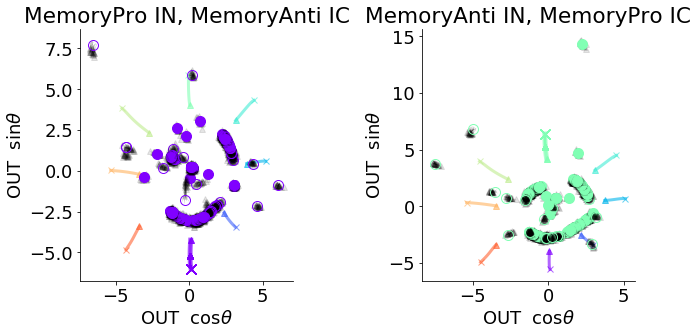

go1
go1


IOError: [Errno 2] No such file or directory: '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_delaygo_delayanti/0/tf_fixed_pts_all_init/delaygo/go1_36.0.npz'

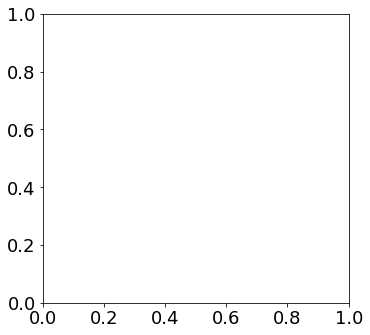

In [20]:
fp_epoch = 'go1'
opp = [1,0]
for offset in range(0,360,36):
    fig = plt.figure(figsize=(10,5),tight_layout=True,facecolor='white')
    
    fp_t_num = [0+offset, 180+offset]
    ind_stim_loc = fp_t_num[0]

    if ind_stim_loc == 0:
        t_num = 0
    else:
        t_num = int(80*ind_stim_loc/360)

    n_fps = 5

    if 'h' in which_net:
        rand_step_coef = 0.0001
    else:
        rand_step_coef = 0.1
        
#     f = os.path.join(m_all,'tf_fixed_pts_all_init',task_list[0],fp_epoch+'_'+str(ind_stim_loc)+'.0.npz')
#     fp_struct = np.load(f)
#     sorted_fps = fp_struct['xstar']
#     pca = PCA(n_components = 2)
#     fp_pca = pca.fit_transform(sorted_fps)
#     D_use = pca.components_.T
    axes_label1 = 'Fixed Pts PC1'
    axes_label2 = 'Fixed Pts PC2'
    
#     D_use,_,_ = make_FP_axs(f,m,task_list[0],fp_epoch,axs ='pca_h', clust = 'False')
    
    use_yinds = [4,5]
    axes_label1 = Y_labels[use_yinds[0]]
    axes_label2 = Y_labels[use_yinds[1]]
    D_use = Beta_qr[:,use_yinds]

    for ri in range(2):
        
        ax1 = plt.subplot(1,2,ri+1)
    #     ax = plt.subplot(1,1,1)

        rule_in = task_list[ri]
        rule_ic = task_list[opp[ri]]
        _, rule_in_name, _, _ = take_names(fp_epoch,rule_in)
        epoch_name, rule_ic_name, _, _ = take_names(fp_epoch,rule_ic)

        f = os.path.join(m_all,'tf_fixed_pts_all_init',rule_in,fp_epoch+'_'+str(fp_t_num[ri])+'.0.npz')
        fp_struct = np.load(f)
        sorted_fps = fp_struct['xstar']
        fp_inds = range(len(sorted_fps))
        qvals = fp_struct['qstar']
        print(qvals)

#         plot_jitter_at_loc(m_all, rule_ic, rule_in, D_use, fp_epoch, t_num, 
#                        rand_step_coef = rand_step_coef, n_steps = 100, n_jit = 1)
    #     plot_N_jitter(m_all,D_use,rule_ic,fp_epoch,rand_step_coef = 0,n_steps = 100,n_jit = 1,
    #                    lw = 3,al = .3,linestyle = ':')
    #     plot_N_jitter(m_all,D_use,rule_in,fp_epoch,rand_step_coef = 0,n_steps = 100,n_jit = 1,
    #                    lw = 3,al = .3,linestyle = '-')

        plot_FP_jitter(m_all,D_use,rule_in,t_num,fp_epoch,sorted_fps,fp_inds,qvals,[rule_in,],
                   rand_step_coef = rand_step_coef, linestyle ='-', n_steps = 10, n_jit = 20)

        tit = rule_in_name + ' IN, ' + rule_ic_name + ' IC'
        plt.title(tit)
        ax1.spines['right'].set_visible(False)
        ax1.spines['top'].set_visible(False)
        plt.xlabel(axes_label1)
        plt.ylabel(axes_label2)

    figname = 'PCS_'+task_list[0]+'_'+task_list[1]+fp_epoch+str(fp_t_num[0])+'_'+tit+'.pdf'
    plt.savefig(os.path.join(figpath,figname))
    plt.show()

In [ ]:
def make_FP_axs(f,m_all,rule_in,fp_epoch,n_fps = 5,axs ='pca', clust = 'False',n_components = 3):
    fp_struct = np.load(f)
    sorted_fps = fp_struct['xstar']

    if (clust == 'True') & (len(sorted_fps)>2):
        kmeans = KMeans(n_clusters=np.min((n_fps,np.shape(fp_struct['xstar'])[0])), random_state=0).fit(sorted_fps)
        _,fp_inds = np.unique(kmeans.labels_,return_index=True)
    
    else:
        fp_inds = range(len(sorted_fps))
        
    if axs == 'tdr':
        D_use = make_axes(m_all,rule_in,fp_epoch)
    elif axs =='pca':
        pca = PCA(n_components = n_components)
        fp_pca = pca.fit_transform(sorted_fps[fp_inds,:])
        D_use = pca.components_.T
    elif axs =='pca_h':
        trial = gen_trials_from_model_dir(m_all,rule_in,mode='random',noise_on = False)
        X, _ = gen_X_from_model_dir_epoch(m_all,trial,fp_epoch)
        pca = PCA(n_components = n_components)
        fp_pca = pca.fit_transform(X.T)
        D_use = pca.components_.T
    elif axs =='out':
        w_in, b_in, w_out, b_out = get_model_params(m_all)
        D_use = w_out[:,1:]

    return D_use, fp_inds, sorted_fps

In [ ]:
def comp_eig_decomp(Ms, sort_by='real',
                                     do_compute_lefts=True):
  """Compute the eigenvalues of the matrix M. No assumptions are made on M.

  Arguments: 
    M: 3D np.array nmatrices x dim x dim matrix
    do_compute_lefts: Compute the left eigenvectors? Requires a pseudo-inverse 
      call.

  Returns: 
    list of dictionaries with eigenvalues components: sorted 
      eigenvalues, sorted right eigenvectors, and sored left eigenvectors 
      (as column vectors).
  """
  if sort_by == 'magnitude':
    sort_fun = np.abs
  elif sort_by == 'real':
    sort_fun = np.real
  else:
    assert False, "Not implemented yet."      
  
  decomps = []
  L = None  
  for M in Ms:
    evals, R = LA.eig(M)    
    indices = np.flipud(np.argsort(sort_fun(evals)))
    if do_compute_lefts:
      L = LA.pinv(R).T  # as columns      
      L = L[:, indices]
    decomps.append({'evals' : evals[indices], 'R' : R[:, indices],  'L' : L})
  
  return decomps

In [ ]:
def plot_FP(X, D, eig_decomps, qvals, c='k'):
    """Plot activity is some 2D space.

        Args:
            X: Fixed points in #Fps x Neurons
            D: Neurons x 2 plotting dims
    
        """
    S = np.shape(X)[0]
    lf = 7
    rf = 7
    
    for s in range(S):
        
        X_trial = np.dot(X[s,:],D.T)
        
        n_arg = np.argwhere(eig_decomps[s]['evals']>1)+1
        if len(n_arg)>0:
            for arg in range(np.max(n_arg)):
                rdots = np.dot(np.real(eig_decomps[s]['R'][:, arg]).T,D.T)
                ldots = np.dot(np.real(eig_decomps[s]['L'][:, arg]).T,D.T)
                overlap = np.dot(rdots,ldots.T)
                r = np.concatenate((X_trial - rf*overlap*rdots, X_trial + rf*overlap*rdots),0)
                plt.plot(r[0:4:2],r[1:4:2], c = c ,alpha = .2,linewidth = .5)
        
        n_arg = np.argwhere(eig_decomps[s]['evals']<.3)
        if len(n_arg)>0:
            for arg in range(np.min(n_arg),len(eig_decomps[s]['evals'])):
                rdots = np.dot(np.real(eig_decomps[s]['R'][:, arg]).T,D.T)
                ldots = np.dot(np.real(eig_decomps[s]['L'][:, arg]).T,D.T)
                overlap = np.dot(rdots,ldots.T)
                r = np.concatenate((X_trial - rf*overlap*rdots, X_trial + rf*overlap*rdots),0)
                plt.plot(r[0:4:2],r[1:4:2],'b',alpha = .2,linewidth = .5)

        if np.log10(qvals[s])>-11:
            mfc = 'None'
        else:
            mfc = c
                
            
        plt.plot(X_trial[0], X_trial[1], 'o', markerfacecolor = mfc, markeredgecolor = c, markersize = 10, alpha = .5)


In [ ]:
def plot_FP_specific(s,X, D, eig_decomps, c='k'):
    """Plot activity is some 2D space.

        Args:
            X: Fixed points in #Fps x Neurons
            D: Neurons x 2 plotting dims
    
        """
    lf = 1000
    rf = 1000
    
    X_trial = np.dot(X[s,:],D.T)
        
    n_arg = np.argwhere(eig_decomps[s]['evals']>1)+1
    if len(n_arg)>0:
        for arg in range(np.max(n_arg)):
            rdots = np.dot(np.real(eig_decomps[s]['R'][:, arg]).T,D.T)
            ldots = np.dot(np.real(eig_decomps[s]['L'][:, arg]).T,D.T)
            overlap = np.dot(rdots,ldots.T)
            r = np.concatenate((X_trial - rf*overlap*rdots, X_trial + rf*overlap*rdots),0)
            plt.plot(r[0:4:2],r[1:4:2],'k',alpha = .5,linewidth = .5)

    n_arg = np.argwhere(eig_decomps[s]['evals']<.3)
    if len(n_arg)>0:
        for arg in range(np.min(n_arg),len(eig_decomps[s]['evals'])):
            rdots = np.dot(np.real(eig_decomps[s]['R'][:, arg]).T,D.T)
            ldots = np.dot(np.real(eig_decomps[s]['L'][:, arg]).T,D.T)
            overlap = np.dot(rdots,ldots.T)
            r = np.concatenate((X_trial - rf*overlap*rdots, X_trial + rf*overlap*rdots),0)
            plt.plot(r[0:4:2],r[1:4:2],'b',alpha = .5,linewidth = .5)

    plt.plot(X_trial[0], X_trial[1], 'o', markerfacecolor = 'none', markeredgecolor = c, 
             markersize = 20, alpha = .5)

In [ ]:
def plot_fp_struct_multicolor(m,tasks,trial_set,D,fp_epoch,sorted_fps,eig_decomps,q_star,do_plot_FP = 1,
                              t_num = 0,qlim = .000001,color_label = 'stim1',alpha_color = 'white',fs = 18):
    cmap=plt.get_cmap('rainbow')
    plt.rcParams.update({'font.size': fs})
    lw = 3
    al = .6

    ## plot w test set of trials
    model = Model(m)
    with tf.Session() as sess:
        model.restore()
        hparams = model.hp
        model._sigma=0

        for rule_ind in range(len(tasks)):
            rule = tasks[rule_ind]
            trial = generate_trials(rule, hparams, mode='test', noise_on=False, delay_fac =1)
            feed_dict = tools.gen_feed_dict(model, trial, hparams)
            h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
            T_inds = get_T_inds(trial,fp_epoch) # grab epoch time indexing
            T,S,N = np.shape(h_tf)
            
            stim1_locs = np.min(trial.stim_locs[:,[0,2]],axis=1)
            stim2_locs = np.min(trial.stim_locs[:,[1,3]],axis=1)
            y_loc = trial.y_loc[-1,:]
            
            if color_label == 'stim1' or color_label == 'delay1':
                c_inds = stim1_locs
            elif color_label == 'stim2' or color_label == 'delay2':
                c_inds = stim2_locs
            else:
                c_inds = y_loc
            
            if do_plot_FP==0:
                for s in trial_set:
                    c = cmap(c_inds[s]/(2*np.pi))
                    X_trial = np.dot(h_tf[T_inds,s,:],D)
                    plt.plot(X_trial[0,0],X_trial[0,1],'x',c = c, alpha = al, linewidth = lw)
                    plt.plot(X_trial[:,0],X_trial[:,1],'-',c = c, alpha = al, linewidth = lw)
                    if alpha_color == 'black':
                        plt.plot(X_trial[0,0],X_trial[0,1],'x',c = 'k', alpha = .3, linewidth = lw)
                        plt.plot(X_trial[:,0],X_trial[:,1],'-',c = 'k', alpha = .3, linewidth = lw)
                    
                    if s==t_num:
                        plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, alpha = al, linewidth = lw,label = rule)
                    else:
                        plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, alpha = al, linewidth = lw)
                    
            elif do_plot_FP==1:
                
                c = 'gray'
                for s in trial_set:
                    X_trial = np.dot(h_tf[T_inds,s,:],D)
                    plt.plot(X_trial[0,0],X_trial[0,1],'x',c = c, alpha = al, linewidth = lw)
                    plt.plot(X_trial[:,0],X_trial[:,1],'-',c = c, alpha = al, linewidth = lw)
                    plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, alpha = al, linewidth = lw)
                
                c = cmap(c_inds[t_num]/(2*np.pi))
                X_trial = np.dot(h_tf[T_inds,t_num,:],D)
                plt.plot(X_trial[0,0],X_trial[0,1],'x',c = c, alpha = al, linewidth = lw)
                plt.plot(X_trial[:,0],X_trial[:,1],'-',c = c, alpha = al, linewidth = lw)
                plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, alpha = al, linewidth = lw ,label = rule)

                plot_FP(sorted_fps, D.T, eig_decomps,q_star, c)
                
            elif do_plot_FP==2:
                
                for s in range(0,S,int(S/8)):
                    filename = f_list[s]

                    if os.path.exists(filename):
                        print(filename)
                        fp_struct = np.load(filename)
                        c = cmap(c_inds[s]/(2*np.pi))
                        if fp_struct['trial_num']%4==0:

                            X_trial = np.dot(h_tf[T_inds,fp_struct['trial_num'],:],D)
                            plt.plot(X_trial[0,0],X_trial[0,1],'x',c = c, alpha = al, linewidth = lw)
                            plt.plot(X_trial[:,0],X_trial[:,1],'-',c = c, alpha = al, linewidth = lw)
                            if s==0:
                                plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, alpha = al, 
                                         linewidth = lw, label = rule)
                            else:
                                plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, alpha = al, linewidth = lw)

                            plot_FP(sorted_fps, D.T, eig_decomps,q_star,c)

#             plt.xlabel(r + ' Beta_' + axes_epoch + ' cos@')
#             plt.ylabel(r + ' Beta_' + axes_epoch + ' sin@')
            if fp_epoch=='fix1':
                plt.title(rule_set_names[rule_ind] + ' Context')
            elif fp_epoch=='stim1':
                plt.title(rule_set_names[rule_ind] + ' Stimulus')
            elif fp_epoch=='delay1':
                plt.title(rule_set_names[rule_ind] + ' Memory')
            elif fp_epoch=='go1':
                plt.title(rule_set_names[rule_ind] + ' Response')

In [ ]:
task_list

In [ ]:
rule_ind

In [ ]:
al = .8
lw = 1
t_num = 0
fp_epoch = 'delay1'
qlim = 1
rule_ind = 0
rule_axs = rule_ind
rule_master = rules_dict['all'][rule_ind]
rand_step_coef = 0.1

offset = 0
t_set = [0+offset, 180+offset]
ind_stim_loc = t_set[0]
trial_set = range(0,80,8)

if ind_stim_loc == 0:
    trial_num = [0,0]
else:
    trial_num = [int(80*ind_stim_loc/360),int(80*ind_stim_loc/360)]

axs = 'pca'
f = os.path.join(m,'tf_fixed_pts_all_init',task_list[rule_axs],'go1'+'_'+str(t_set[rule_axs])+'.0.npz')
D_use,_,_ = make_FP_axs(f,m,task_list[rule_axs],'go1',axs =axs, clust = 'False',n_components = 2)
axes_label1 = 'pca_1'
axes_label2 = 'pca_2'
axes_label3 = 'pca_3'

trial = gen_trials_from_model_dir(m,task_list[rule_axs],mode='test',noise_on = False)
T_inds = get_T_inds(trial,fp_epoch)
_, x = gen_X_from_model_dir(m,trial,d = [])
h_tf = x[:,t_num,T_inds[-1]]

f = os.path.join(m,'tf_fixed_pts_all_init',task_list[rule_axs],fp_epoch+'_'+str(0)+'.0.npz')
fp_struct = np.load(f)
# fp_inds = np.argsort(fp_struct['qstar'])
fp_inds = np.argsort([LA.norm(fp_struct['xstar'][s,:] - h_tf) for s in range(len(fp_struct['qstar']))])
sorted_fps = fp_struct['xstar']
eig_decomps = comp_eig_decomp(fp_struct['J_xstar'][:,:,:])
q_star = fp_struct['qstar'][:]

xs = np.linspace(-1, 1, 1000)
ys = np.sqrt(1 - xs**2)

for s in fp_inds:
    fig = plt.figure(figsize=(15,5),tight_layout=True,facecolor='white')
    ax = plt.subplot(1,3,1)
    plot_fp_struct_multicolor(m,[task_list[rule_axs],],trial_set,D_use,fp_epoch,sorted_fps,eig_decomps,q_star,
                              do_plot_FP=1,t_num = t_num,qlim = qlim)
    plot_FP_specific(s,sorted_fps, D_use.T, eig_decomps, c = 'r') 
    
#     x_t = np.matlib.repmat(trial.x[T_inds[1],t_num,:],100,1)
#     h_0 = x[:,t_num,T_inds[0]-1] 
#     h_t = vanilla_run_with_h0(params, x_t, h0, alpha)
#     jitter = np.dot(h_t,D_use)
#     plt.plot(jitter[-1,0],jitter[-1,1],'^k',linewidth = .1,alpha = .2)
#     plt.plot(jitter[:,0],jitter[:,1],'-k',linewidth = 1,alpha = .5)
    
    plt.xlabel(axes_label1)
    plt.ylabel(axes_label2)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
#     plt.ylim((-7,7))    
#     plt.xlim((-4,4))
    
    ax = plt.subplot(1,3,2)
    
#     plt.plot([1,1],[-.1,.1],':k')
    plt.plot(eig_decomps[s]['evals'].real,eig_decomps[s]['evals'].imag,'.')
    plt.plot(xs, ys,':k')
    plt.plot(xs, -ys,':k')
    plt.ylim((-.5,.5))    
    plt.xlim((.3,1.3))
    
    plt.title(str(s)+ ' : ' + str(q_star[s]))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    
    n_steps = 5
    ax = plt.subplot(1,3,3)
    
    x_t = np.matlib.repmat(trial.x[T_inds[1],t_num,:],n_steps,1)
    for jit in range(10):
        del_h = rand_step_coef*npr.randn(n_rnn)
        h0 = sorted_fps[s,:] + del_h
        
        #nonlinear system
        h_t = vanilla_run_with_h0(params, x_t, h0, alpha)
        jitter = np.dot(h_t,D_use)
        plt.plot(jitter[1,0],jitter[1,1],'^k',linewidth = .1,alpha = .2)
        plt.plot(jitter[:2,0],jitter[:2,1],'-k',linewidth = 1,alpha = .5)
        
        #linear system
        h1 = sorted_fps[s,:] + np.dot(fp_struct['J_xstar'][s,:,:],del_h)
        h_t = np.concatenate((h0[np.newaxis,:],h1[np.newaxis,:]),axis = 0)
        jitter = np.dot(h_t,D_use)
        plt.plot(jitter[1,0],jitter[1,1],'^b',linewidth = .1,alpha = .2)
        plt.plot(jitter[:2,0],jitter[:2,1],'-b',linewidth = 1,alpha = .5)

    plt.show()